* 先调一个 8/9/10 的最佳模型出来
* 然后用调出来的模型销量填进去, 使用 Baseline/XGBoost/LGB 三种方法检验一番
* 为的是整体填充这种方法到底靠不靠谱

# 验证 Baseline

* 验证 8/9/10 三个月的 Baseline

## 去拿最佳 baseline

In [810]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import lightgbm as lgb
import xgboost as xgb
from scipy.stats import norm, skew

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [811]:
train = pd.read_csv('../../raw/LiChuan/dataset.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')
trainFeature = pd.read_csv('../../raw/LiChuan/train_feature.csv')

In [156]:
test = train[-140:]
train = train[:-140]

In [157]:
train = train[-560:]

In [168]:
labels_Jun = train[train['month']==7]['sale_quantity_this_last_month'].values
labels_July = train[train['month']==7]['sale_quantity'].values
labels_August = train[train['month']==8]['sale_quantity'].values
labels_Sep = train[train['month']==9]['sale_quantity'].values
labels_Oct = train[train['month']==10]['sale_quantity'].values

In [183]:
sp.sqrt(sp.mean((labels_Jun*1.06 - labels_July) ** 2))

132.7164425812739

In [ ]:
# RMSE132.71
base_Jul = labels_Jun*1.06

In [170]:
sp.sqrt(sp.mean((labels_July*0.84 - labels_August) ** 2))

122.82187669257343

In [184]:
# RMSE122.82
base_Aug = labels_July*0.84

In [171]:
sp.sqrt(sp.mean((labels_August*1.1 - labels_Sep) ** 2))

136.86459862631702

In [185]:
# RMSE136.86
base_Sep = labels_August*1.1

In [172]:
sp.sqrt(sp.mean((labels_July*0.96 - labels_Sep) ** 2))

156.56038513712758

In [173]:
sp.sqrt(sp.mean((labels_Sep*0.91 - labels_Oct) ** 2))

130.88620042944612

In [174]:
sp.sqrt(sp.mean((labels_August - labels_Oct) ** 2))

182.73147746664463

得到最佳 baseline model

* Jun×0.84/Aug RMSE=131
* Aug×1.1/Sep RMSE=136.86
* Jun×0.84×1.1/Sep RMSE=157.13
* Sep×0.91/Oct RMSE=130.88
* Aug×1.1×0.91/Oct RMSE=182.73

* 显而易见, 直接用 baseline 来乘, 肯定不可取, 好的话 150+, 不好的话 180+
* 原因猜测是, 有一些8月没有, 10月有的车型
* 除此之外, 两个月销量的波动太大了,怎么调也调不好

* 先调一个 8/9/10 的最佳模型出来
* 然后用调出来的模型销量填进去, 使用 Baseline/XGBoost/LGB 三种方法检验一番

## 去拿 XGBoost

In [193]:
data = pd.read_csv('../../raw/LiChuan/XGBoostFeatures.csv')

In [194]:
# 去掉 2012 年数据
data = data[data['year'] != 2012]
labels = data['sale_quantity']
data = data.drop(['sale_date', 'class_id', 'sale_quantity'], axis=1)

In [195]:
# 训练集 2013-01 至 2017-07, 测试集 2017-08
train_1 = data[:-560]
test_1 = data[-560:-420]
labels_1 = labels[:-560]
test_labels_1 = labels[-560:-420]

# 训练集 2013-01 至 2017-08, 测试集 2017-09
train_2 = data[:-420]
test_2 = data[-420:-280]
labels_2 = labels[:-420]
test_labels_2 = labels[-420:-280]

# 训练集 2013-01 至 2017-06, 测试集 2017-07
train_3 = data[:-700]
test_3 = data[-700:-560]
labels_3 = labels[:-700]
test_labels_3 = labels[-700:-560]

In [196]:
trainset_1 = xgb.DMatrix(train_1, label=labels_1)
testset_1 = xgb.DMatrix(test_1)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_1 = xgb.train(params, trainset_1, num_boost_round=3000)
predict_xgb_1 = model_1.predict(testset_1)
rmsetmp_1 = sp.sqrt(sp.mean((test_labels_1 - predict_xgb_1) ** 2))

print('This time rmse is: '+ str(rmsetmp_1))

This time rmse is: 140.688030113


In [197]:
trainset_2 = xgb.DMatrix(train_2, label=labels_2)
testset_2 = xgb.DMatrix(test_2)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_2 = xgb.train(params, trainset_2, num_boost_round=3000)
predict_xgb_2 = model_2.predict(testset_2)
rmsetmp_2 = sp.sqrt(sp.mean((test_labels_2 - predict_xgb_2) ** 2))

print('This time rmse is: '+ str(rmsetmp_2))

This time rmse is: 121.516453971


In [198]:
trainset_3 = xgb.DMatrix(train_3, label=labels_3)
testset_3 = xgb.DMatrix(test_3)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L3 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_3 = xgb.train(params, trainset_3, num_boost_round=3000)
predict_xgb_3 = model_3.predict(testset_3)
rmsetmp_3 = sp.sqrt(sp.mean((test_labels_3 - predict_xgb_3) ** 2))

print('This time rmse is: '+ str(rmsetmp_3))

This time rmse is: 125.84137719


In [199]:
print('The average rmse is: '+ str((rmsetmp_1 + rmsetmp_2 + rmsetmp_3)/3))

The average rmse is: 129.348620425


* 得到三个 XGBoost

## 去拿 LGB

In [200]:
data = pd.read_csv('../../raw/LiChuan/dataset.csv')

In [201]:
# 去掉 2012 年数据
data = data[data['year'] != 2012]
labels = data['sale_quantity']
data = data.drop(['sale_date', 'class_id', 'sale_quantity'], axis=1)

In [202]:
# 训练集 2013-01 至 2017-07, 测试集 2017-08
train_1 = data[:-560]
test_1 = data[-560:-420]
labels_1 = labels[:-560]
test_labels_1 = labels[-560:-420]

# 训练集 2013-01 至 2017-08, 测试集 2017-09
train_2 = data[:-420]
test_2 = data[-420:-280]
labels_2 = labels[:-420]
test_labels_2 = labels[-420:-280]

# 训练集 2013-01 至 2017-06, 测试集 2017-07
train_3 = data[:-700]
test_3 = data[-700:-560]
labels_3 = labels[:-700]
test_labels_3 = labels[-700:-560]

In [203]:
# 8 月
lgb_train_1 = lgb.Dataset(train_1, labels_1)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model_1 = lgb.train(params, lgb_train_1, 900)
lgb_pred_1 = model_1.predict(test_1)
rmsetmp_1 = sp.sqrt(sp.mean((test_labels_1 - lgb_pred_1) ** 2))

print('This time rmse is: '+ str(rmsetmp_1))

This time rmse is: 124.901886283


In [204]:
# 9月
lgb_train_2 = lgb.Dataset(train_2, labels_2)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model_2 = lgb.train(params, lgb_train_2, 1000)
lgb_pred_2 = model_2.predict(test_2)
rmsetmp_2 = sp.sqrt(sp.mean((test_labels_2 - lgb_pred_2) ** 2))

print('This time rmse is: '+ str(rmsetmp_2))

This time rmse is: 112.545135865


In [205]:
# 7月
lgb_train_3 = lgb.Dataset(train_3, labels_3)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model_3 = lgb.train(params, lgb_train_3, 1145)
lgb_pred_3 = model_3.predict(test_3)
rmsetmp_3 = sp.sqrt(sp.mean((test_labels_3 - lgb_pred_3) ** 2))

print('This time rmse is: '+ str(rmsetmp_3))

This time rmse is: 129.402211594


In [206]:
print('The average rmse is: '+ str((rmsetmp_1 + rmsetmp_2 + rmsetmp_3)/3))

The average rmse is: 122.283077914


## 融合一波走起

### 7 月

132/125/129 三个单模型
lgb_pred_3/predict_xgb_3/labels_Jun

In [221]:
sp.sqrt(sp.mean((lgb_pred_3*0.44 + predict_xgb_3*0.56 - labels_July) ** 2))

119.48209369098326

In [255]:
# RMSE=119.48
pred_Jul = lgb_pred_3*0.45 + predict_xgb_3*0.55

### 8 月

124/140/122.82 三个单模型
lgb_pred_1/predict_xgb_1/base_Aug

In [232]:
sp.sqrt(sp.mean((lgb_pred_1*0.5 + base_Aug*0.5 - labels_August) ** 2))

118.49122332149284

In [227]:
sp.sqrt(sp.mean((lgb_pred_1 - predict_xgb_1) ** 2))

90.592720824463058

In [254]:
# RMSE=118.49
pred_Aug = lgb_pred_1*0.5 + base_Aug*0.5

### 9 月

112.54/121.51/136.86 三个单模型
lgb_pred_2/predict_xgb_2/base_Sep

In [238]:
sp.sqrt(sp.mean((lgb_pred_2*0.8 + predict_xgb_2*0.2 - labels_Sep) ** 2))

108.46453241503441

In [239]:
# RMSE=108.46
pred_Sep = lgb_pred_2*0.8 + predict_xgb_2*0.2

## 去填

### 首先测试 baseline

In [263]:
# 检测 8 月, 用 pred_Jul
sp.sqrt(sp.mean((pred_Jul*0.9 - labels_August) ** 2))

141.23046974204797

In [352]:
base_Aug = pred_Jul*0.9

In [267]:
# 检测 9 月, 用 pred_Aug
sp.sqrt(sp.mean((pred_Aug*1.1 - labels_Sep) ** 2))

140.75664551319548

In [353]:
base_Sep = pred_Aug*1.1

In [273]:
# 检测 10 月, 用 pred_Sep
sp.sqrt(sp.mean((pred_Sep*0.92 - labels_Oct) ** 2))

148.82296998155411

In [354]:
base_Oct = pred_Sep*0.92

In [274]:
# 8/9/10 三个月平均
(141.23 + 140.75 + 148.82)/3

143.6

运用整体填充法, baseline 本地测试平均结果 143.6

### 接着测试 XGBoost

In [875]:
data = pd.read_csv('../../raw/LiChuan/XGBoostFeatures.csv')

In [876]:
# 去掉 2012 年数据
data = data[data['year'] != 2012]
labels = data['sale_quantity']
data = data.drop(['sale_date', 'class_id', 'sale_quantity'], axis=1)

In [877]:
# 训练集 2013-01 至 2017-07, 测试集 2017-08
train_1 = data[:-560]
test_1 = data[-560:-420]
labels_1 = labels[:-560]
test_labels_1 = labels[-560:-420]

# 训练集 2013-01 至 2017-08, 测试集 2017-09
train_2 = data[:-420]
test_2 = data[-420:-280]
labels_2 = labels[:-420]
test_labels_2 = labels[-420:-280]

# 训练集 2013-01 至 2017-09, 测试集 2017-10
train_3 = data[:-280]
test_3 = data[-280:-140]
labels_3 = labels[:-280]
test_labels_3 = labels[-280:-140]

In [878]:
# 如果直接对 labels 进行操作的话, test_labels 也会随着改变, 所以使用 copy 操作
label_1 = labels_1.copy()
label_2 = labels_2.copy()
label_3 = labels_3.copy()

In [879]:
# 分别用预测最佳值, 填充
label_1[-140:] = pred_Jul
label_2[-140:] = pred_Aug
label_3[-140:] = pred_Sep

In [817]:
# 测试 XGBoost 三种情况得分

In [349]:
trainset_1 = xgb.DMatrix(train_1, label=label_1)
testset_1 = xgb.DMatrix(test_1)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_1 = xgb.train(params, trainset_1, num_boost_round=3000)
predict_xgb_1 = model_1.predict(testset_1)
rmsetmp_1 = sp.sqrt(sp.mean((test_labels_1 - predict_xgb_1) ** 2))

print('This time rmse is: '+ str(rmsetmp_1))

This time rmse is: 141.487368184


In [350]:
trainset_2 = xgb.DMatrix(train_2, label=label_2)
testset_2 = xgb.DMatrix(test_2)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_2 = xgb.train(params, trainset_2, num_boost_round=3000)
predict_xgb_2 = model_2.predict(testset_2)
rmsetmp_2 = sp.sqrt(sp.mean((test_labels_2 - predict_xgb_2) ** 2))

print('This time rmse is: '+ str(rmsetmp_2))

This time rmse is: 155.798817456


In [351]:
trainset_3 = xgb.DMatrix(train_3, label=label_3)
testset_3 = xgb.DMatrix(test_3)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L3 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_3 = xgb.train(params, trainset_3, num_boost_round=3000)
predict_xgb_3 = model_3.predict(testset_3)
rmsetmp_3 = sp.sqrt(sp.mean((test_labels_3 - predict_xgb_3) ** 2))

print('This time rmse is: '+ str(rmsetmp_3))

This time rmse is: 143.856585039


In [355]:
# 三个月平均
(141.48 + 155.79 + 143.85)/3

147.04

* 运用整体填充发, XGBoost 本地测试平均结果为 147.04

### 测试 LGB

In [866]:
data = pd.read_csv('../../raw/LiChuan/dataset.csv')

In [867]:
# 去掉 2012 年数据/同时把上月销量去了先
data = data[data['year'] != 2012]
labels = data['sale_quantity']
data = data.drop(['sale_date', 'class_id', 'sale_quantity'], axis=1)

In [868]:
# 训练集 2013-01 至 2017-07, 测试集 2017-08
train_1 = data[:-560]
test_1 = data[-560:-420]
labels_1 = labels[:-560]
test_labels_1 = labels[-560:-420]

# 训练集 2013-01 至 2017-08, 测试集 2017-09
train_2 = data[:-420]
test_2 = data[-420:-280]
labels_2 = labels[:-420]
test_labels_2 = labels[-420:-280]

# 训练集 2013-01 至 2017-09, 测试集 2017-10
train_3 = data[:-280]
test_3 = data[-280:-140]
labels_3 = labels[:-280]
test_labels_3 = labels[-280:-140]

In [869]:
# 如果直接对 labels 进行操作的话, test_labels 也会随着改变, 所以使用 copy 操作
label_1 = labels_1.copy()
label_2 = labels_2.copy()
label_3 = labels_3.copy()

In [870]:
# 分别用预测最佳值, 填充
label_1[-140:] = pred_Jul
label_2[-140:] = pred_Aug
label_3[-140:] = pred_Sep

In [871]:
# 8 月
lgb_train_1 = lgb.Dataset(train_1, label_1)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model_1 = lgb.train(params, lgb_train_1, 800)
lgb_pred_1 = model_1.predict(test_1)
rmsetmp_1 = sp.sqrt(sp.mean((test_labels_1 - lgb_pred_1) ** 2))

print('This time rmse is: '+ str(rmsetmp_1))

This time rmse is: 125.553050383


In [872]:
# 9月
lgb_train_2 = lgb.Dataset(train_2, label_2)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model_2 = lgb.train(params, lgb_train_2, 1000)
lgb_pred_2 = model_2.predict(test_2)
rmsetmp_2 = sp.sqrt(sp.mean((test_labels_2 - lgb_pred_2) ** 2))

print('This time rmse is: '+ str(rmsetmp_2))

This time rmse is: 116.069248166


In [873]:
# 10月
lgb_train_3 = lgb.Dataset(train_3, label_3)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model_3 = lgb.train(params, lgb_train_3, 1000)
lgb_pred_3 = model_3.predict(test_3)
rmsetmp_3 = sp.sqrt(sp.mean((test_labels_3 - lgb_pred_3) ** 2))

print('This time rmse is: '+ str(rmsetmp_3))

This time rmse is: 128.627683832


In [874]:
print('The average rmse is: '+ str((rmsetmp_1 + rmsetmp_2 + rmsetmp_3)/3))

The average rmse is: 123.416660794


* 运用整体填充法,  
    * LGB 本地测试平均结果为 123.88
    * 8月 127.26/ 9月 116.06/ 10月 128.31
* 把不准的上月销量去了再测 123.71
    * 8月 122.91/ 9月 121.27/ 10月 127.42
* 去了以后似乎方差减小了, 结果倒是差不多

### 简单融合一波

In [369]:
# base_Aug=141.23, lgb_pred_1=127.26
sp.sqrt(sp.mean((test_labels_1 - lgb_pred_1 * 0.85 - base_Aug*0.15) ** 2))

126.49174727516967

In [374]:
# base_Sep=140.75, lgb_pred_2=116.06
sp.sqrt(sp.mean((test_labels_2 - lgb_pred_2) ** 2))

116.06924816629072

In [377]:
# base_Oct=148.82, lgb_pred_3=128.31
sp.sqrt(sp.mean((test_labels_3 - lgb_pred_3) ** 2))

128.31250397280482

## 接着测试 XGBoost, 必须利用时间窗口来平抑

1. 去掉上月销量, 用时间窗口的平均值来填充, 误差太大不得行
2. 保留全部窗口试试, 不得行 155
3. 环比去了再试试, 误差既大且小, 提交一版去试试水
4. 咦, sum 去了效果不错
5. std 去不得
6. 试试 median, 去不得
7. 试试 mean, 还不行
8. 试试 min, 效果都不显
9. 皮尔森相关系数研究研究
10. 相关高的留一个也够呛

In [1245]:
data = pd.read_csv('../../raw/LiChuan/dataset.csv')

In [1246]:
# 'sale_quantity_last_2M_sum','sale_quantity_last_2M_max','sale_quantity_last_2M_min','sale_quantity_last_2M_std','sale_quantity_last_2M_median', 'sale_quantity_last_3M_sum','sale_quantity_last_3M_max','sale_quantity_last_3M_min','sale_quantity_last_3M_std','sale_quantity_last_3M_median', 'sale_quantity_last_6M_sum','sale_quantity_last_6M_max','sale_quantity_last_6M_min','sale_quantity_last_6M_std','sale_quantity_last_6M_median', 'sale_quantity_last_12M_sum','sale_quantity_last_12M_max','sale_quantity_last_12M_min','sale_quantity_last_12M_std','sale_quantity_last_12M_median'

In [1247]:
# 去掉 2012 年数据
data = data[data['year'] != 2012]
labels = data['sale_quantity']
data = data.drop(['sale_date', 'class_id', 'sale_quantity', 'month_relative_ratio_12M_ago'], axis=1)

In [1248]:
data = data.drop(['sale_quantity_last_2M_sum', 'sale_quantity_last_3M_sum', 'sale_quantity_last_6M_sum', 'sale_quantity_last_12M_sum'], axis=1)
data = data.drop(['sale_quantity_last_2M_max', 'sale_quantity_last_3M_max', 'sale_quantity_last_6M_max', 'sale_quantity_last_12M_max'], axis=1)
data = data.drop(['sale_quantity_last_2M_min', 'sale_quantity_last_3M_min', 'sale_quantity_last_6M_min', 'sale_quantity_last_12M_min'], axis=1)
#data = data.drop(['sale_quantity_last_2M_mean', 'sale_quantity_last_3M_mean', 'sale_quantity_last_6M_mean', 'sale_quantity_last_12M_mean'], axis=1)
data = data.drop(['sale_quantity_last_2M_median', 'sale_quantity_last_3M_median', 'sale_quantity_last_6M_median', 'sale_quantity_last_12M_median'], axis=1)
#data = data.drop(['sale_quantity_last_2M_std', 'sale_quantity_last_3M_std', 'sale_quantity_last_6M_std', 'sale_quantity_last_12M_std'], axis=1)

In [1249]:
# 训练集 2013-01 至 2017-07, 测试集 2017-08
train_1 = data[:-560]
test_1 = data[-560:-420]
labels_1 = labels[:-560]
test_labels_1 = labels[-560:-420]

# 训练集 2013-01 至 2017-08, 测试集 2017-09
train_2 = data[:-420]
test_2 = data[-420:-280]
labels_2 = labels[:-420]
test_labels_2 = labels[-420:-280]

# 训练集 2013-01 至 2017-09, 测试集 2017-10
train_3 = data[:-280]
test_3 = data[-280:-140]
labels_3 = labels[:-280]
test_labels_3 = labels[-280:-140]

In [1250]:
train = data[:-140]
label = labels[:-140]
test = data[-140:]

In [1251]:
# 如果直接对 labels 进行操作的话, test_labels 也会随着改变, 所以使用 copy 操作
label_1 = labels_1.copy()
label_2 = labels_2.copy()
label_3 = labels_3.copy()

In [1252]:
# 分别用预测最佳值, 填充
label_1[-140:] = pred_Jul
label_2[-140:] = pred_Aug
label_3[-140:] = pred_Sep

In [1178]:
trainset_1 = xgb.DMatrix(train_1, label=label_1)
testset_1 = xgb.DMatrix(test_1)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_1 = xgb.train(params, trainset_1, num_boost_round=3000)
predict_xgb_1 = model_1.predict(testset_1)
rmsetmp_1 = sp.sqrt(sp.mean((test_labels_1 - predict_xgb_1) ** 2))

print('This time rmse is: '+ str(rmsetmp_1))

This time rmse is: 152.349207071


In [1179]:
trainset_2 = xgb.DMatrix(train_2, label=label_2)
testset_2 = xgb.DMatrix(test_2)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_2 = xgb.train(params, trainset_2, num_boost_round=3000)
predict_xgb_2 = model_2.predict(testset_2)
rmsetmp_2 = sp.sqrt(sp.mean((test_labels_2 - predict_xgb_2) ** 2))

print('This time rmse is: '+ str(rmsetmp_2))

This time rmse is: 190.019191153


In [1180]:
trainset_3 = xgb.DMatrix(train_3, label=label_3)
testset_3 = xgb.DMatrix(test_3)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L3 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_3 = xgb.train(params, trainset_3, num_boost_round=3000)
predict_xgb_3 = model_3.predict(testset_3)
rmsetmp_3 = sp.sqrt(sp.mean((test_labels_3 - predict_xgb_3) ** 2))

print('This time rmse is: '+ str(rmsetmp_3))

This time rmse is: 143.865216514


In [1181]:
print('The average rmse is: '+ str((rmsetmp_1 + rmsetmp_2 + rmsetmp_3)/3))

The average rmse is: 162.077871579


* 留 min/std/mean 137
* 留 min/std/median 139
* 去掉 sum/median

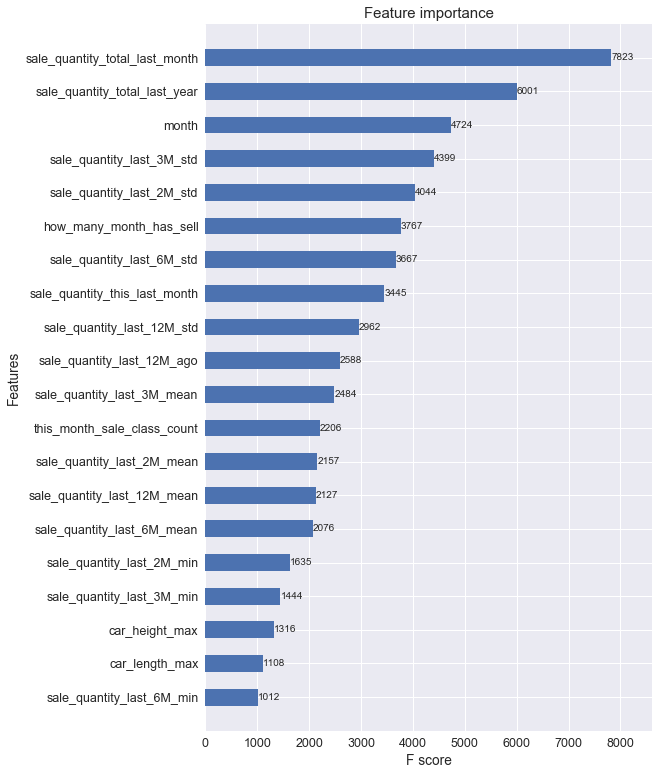

In [1169]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model_3, max_num_features=20, height=0.5, ax=ax)

## RandomForest 研究

RandomForestRegressor(n_estimators=n_estimators,random_state=random_state,n_jobs=n_jobs)

In [880]:
from sklearn.ensemble import RandomForestRegressor

In [1037]:
Model = RandomForestRegressor(n_estimators = 28, n_jobs=-1)

In [1038]:
Model.fit(X = train_1, y = label_1)

y_pred_1 = Model.predict(X = test_1)

In [1039]:
sp.sqrt(sp.mean((test_labels_1 - y_pred_1) ** 2))

174.39705806936954

In [884]:
Model.fit(X = train_2, y = label_2)

y_pred_2 = Model.predict(X = test_2)

In [885]:
sp.sqrt(sp.mean((test_labels_2 - y_pred_2) ** 2))

180.725446634018

In [886]:
Model.fit(X = train_3, y = label_3)

y_pred_3 = Model.predict(X = test_3)

In [887]:
sp.sqrt(sp.mean((test_labels_3 - y_pred_3) ** 2))

161.62550311861187

In [643]:
(168.76 + 146.15 + 137.15)/3

150.68666666666664

## GBDT 研究

In [888]:
from sklearn.ensemble import GradientBoostingRegressor

In [1253]:
est_1 = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.008,
                                   max_depth=5, max_features='sqrt', alpha=0.95,
                                   min_samples_leaf=13, min_samples_split=10,
                                   loss='huber').fit(train_1, label_1)

In [1254]:
rmse_1 = sp.sqrt(sp.mean((test_labels_1 - est_1.predict(test_1)) ** 2))
print(rmse_1)

138.143945082


In [1255]:
est_2 = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.008,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=13, min_samples_split=10,
                                   loss='huber').fit(train_2, label_2)

In [1256]:
rmse_2 = sp.sqrt(sp.mean((test_labels_2 - est_2.predict(test_2)) ** 2))
print(rmse_2)

144.938853604


In [1257]:
est_3 = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.008,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=13, min_samples_split=10,
                                   loss='huber').fit(train_3, label_3)

In [1258]:
rmse_3 = sp.sqrt(sp.mean((test_labels_3 - est_2.predict(test_3)) ** 2))
print(rmse_3)

137.739826781


In [1259]:
(rmse_1 + rmse_2 + rmse_3)/3

140.27420848920664

* 好吧,  GBDT 效果不错, 继续仔细挖掘
* 继续测试, 不填数据一波试试
* 调参一波, 话说训练速度也太慢了
* 加窗口效果和 XGBoost 差不多

* 全特征,
    * n_estimators/5000 平均 140.79 ; 6000/142; 4000/141.11; 4800/145.85
    * learning_rate/0.007 平均 143.53
    * max_depth/4 平均 145.02
    * min_samples_leaf/14 平均 140.61 13/140.05; 12/141.75
    * min_samples_split/20 平均 142.90; 12/142.21; 9/143.42; 10/142.22
* 去掉上月销量(保留)
    * 146.36/148.05
* 去掉去年环比(可以去)
    * 139.99
* 去掉 sum (不能去掉)
    * 145.57
* 保留 mean/std
    * 138